# Training with pipeline

In [1]:
from lib.pipeline import Pipeline
pipeline_kwargs = {
    'model': 'gearnet',
    'dataset': 'atpbind3d-minimal',
    'gpus': [0],
    'model_kwargs': {
        'input_dim': 21,
        'hidden_dims': [512] * 4,
        'gpu': 0,
    },
    'optimizer_kwargs': {'lr': 2e-3},
    'task_kwargs': {
        'normalization': False,
        'num_mlp_layer': 2,
        'metric': ['mcc'],
    },
    'batch_size': 1,
    'gradient_interval': 1,
    'verbose': False,
    'valid_fold_num': 0,
    'dataset_kwargs': {
        'to_slice': True,
        'max_slice_length': 550,
        'padding': 100
    },
    'num_mlp_layer': 2,
}
pipeline = Pipeline(**pipeline_kwargs)

train_record = pipeline.train_until_fit(max_epoch=10, eval_testset_intermediate=False)

init pipeline, model: gearnet, dataset: atpbind3d-minimal, gpus: [0]
load model gearnet, kwargs: {'input_dim': 21, 'hidden_dims': [512, 512, 512, 512], 'gpu': 0}
get dataset with kwargs: {'to_slice': True, 'max_slice_length': 550, 'padding': 100}
get dataset atpbind3d-minimal
12:41:44   ATPBind3D: loaded 10 proteins and 10 targets
12:41:44   ATPBind3D: sliced original data into 11 proteins
12:41:46   ATPBind3D: loaded 11 gvp graphs. length of data: 11
Initialize Undersampling: all ones
Initialize Weighting: all ones
train samples: 4, valid samples: 2, test samples: 5
no scheduler
pipeline batch_size: 1, gradient_interval: 1
0m1s {'valid_mcc': 0.0, 'train_bce': 0.9625, 'valid_bce': 13.1299, 'best_threshold': -1.7}
0m0s {'valid_mcc': -0.0154, 'train_bce': 0.5717, 'valid_bce': 6.7073, 'best_threshold': 1.0}
0m0s {'valid_mcc': -0.0268, 'train_bce': 0.1987, 'valid_bce': 1.3338, 'best_threshold': 1.0}
0m0s {'valid_mcc': 0.0924, 'train_bce': 0.0997, 'valid_bce': 0.9758, 'best_threshold': 1.0}

In [ ]:
%matplotlib inline
from lib.utils import protein_to_sequence
from torch.nn import functional as F
from torchdrug import data
from lib.pipeline import graph_collate_with_gvp
from lib.lr_scheduler import CyclicLR
import torch
from torchdrug import utils
def make_gvp_test_pipeline(num_layers=1, node_h_dim=(100, 16), edge_h_dim=(32, 1), drop_rate=0.1, model='gvp'):
    pipeline_kwargs = {
        'model': model,
        'dataset': 'atpbind3d-minimal',
        'gpus': [0],
        'model_kwargs': {
            'node_in_dim': (6, 3),
            'node_h_dim': node_h_dim,
            'edge_in_dim': (32, 1),
            'edge_h_dim': edge_h_dim,
            'num_layers': num_layers,
            'drop_rate': drop_rate,
            'output_dim': 20,
            'gpu': 0,
        },
        'scheduler': 'cyclic',
        'scheduler_kwargs': {
            'base_lr': 3e-4,
            'max_lr': 3e-3,
            'step_size_up': 125,
            'step_size_down': 125,
            'cycle_momentum': False
        },
        'task_kwargs': {
            'normalization': False,
            'num_mlp_layer': 2,
            'metric': ['mcc'],
            'node_feature_type': 'gvp_data',
        },
        'batch_size': 1,
        'gradient_interval': 1,
        'verbose': False,
        'valid_fold_num': 0,
        'dataset_kwargs': {
            'to_slice': True,
            'max_slice_length': 550,
            'padding': 100
        },
        'num_mlp_layer': 2,
    }
    return Pipeline(**pipeline_kwargs)

def make_gearnet_test_pipeline():
    pipeline_kwargs = {
        'model': 'gearnet',
        'dataset': 'atpbind3d-minimal',
        'gpus': [0],
        'model_kwargs': {
            'input_dim': 21,
            'hidden_dims': [512] * 4,
            'gpu': 0,
        },
        'optimizer_kwargs': {'lr': 2e-3},
        'task_kwargs': {
            'normalization': False,
            'num_mlp_layer': 2,
            'metric': ['mcc'],
        },
        'batch_size': 1,
        'gradient_interval': 1,
        'verbose': False,
        'valid_fold_num': 0,
        'dataset_kwargs': {
            'to_slice': True,
            'max_slice_length': 550,
            'padding': 100
        },
        'num_mlp_layer': 2,
    }
    return Pipeline(**pipeline_kwargs)


def simulate_overfitting(pipeline, iteration=100):
    task = pipeline.task

    # Get a batch from the train set
    train_loader = data.DataLoader(
        pipeline.train_set,
        batch_size=pipeline.batch_size,
        shuffle=False,
        collate_fn=graph_collate_with_gvp
    )
    batch = next(iter(train_loader))
    batch = utils.cuda(batch, device=torch.device(f'cuda:{pipeline.gpus[0]}'))
    task.eval()
    predicted = task.predict(batch)
    print(f'task.model: {type(task.model)}')
    print(f'sequence: {protein_to_sequence(batch["graph"])[29:39]}')
    print(f'prediction: {predicted[29:39].flatten()}')
    print(f'label: {batch["graph"].target[29:39].flatten()}')
    bce_loss = F.binary_cross_entropy_with_logits(
        predicted[29:39], batch["graph"].target[29:39].float())
    print(f'bce loss: {bce_loss}')

    print('Overfitting...')
    task.train()
    optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
    scheduler = CyclicLR(
        optimizer, 
        base_lr=3e-4, 
        max_lr=3e-3, 
        step_size_up=iteration // 2,
        step_size_down=iteration // 2,
        cycle_momentum=False,
    )
    lr_list = []
    loss_list = []
    for i in range(iteration):
        loss, metric = task(batch)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        lr_list.append(scheduler.get_last_lr()[0])
    task.eval()
    predicted = task.predict(batch)
    print(f'sequence: {protein_to_sequence(batch["graph"])[29:39]}')
    print(f'prediction: {predicted[29:39].flatten()}')
    print(f'label: {batch["graph"].target[29:39].flatten()}')
    new_bce_loss = F.binary_cross_entropy_with_logits(
        predicted[29:39], batch["graph"].target[29:39].float())
    print(f'new bce loss: {new_bce_loss}')
    print(f'loss decrease: {bce_loss - new_bce_loss}')

    # Plot the loss over iterations
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_list) + 1), loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs. Iteration during Overfitting')
    plt.grid(True)
    plt.show()
    
    # Plot the learning rate over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(lr_list) + 1), lr_list)
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Iteration during Overfitting')
    plt.grid(True)
    plt.show()

init pipeline, model: gvp-encoder, dataset: atpbind3d-minimal, gpus: [0]
load model gvp-encoder, kwargs: {'node_in_dim': (6, 3), 'node_h_dim': (100, 16), 'edge_in_dim': (32, 1), 'edge_h_dim': (32, 1), 'num_layers': 3, 'drop_rate': 0.1, 'output_dim': 20, 'gpu': 0}
get dataset with kwargs: {'to_slice': True, 'max_slice_length': 550, 'padding': 100}
Initialize Undersampling: all ones
Initialize Weighting: all ones
train samples: 4, valid samples: 2, test samples: 5
use cyclic lr scheduler
pipeline batch_size: 1, gradient_interval: 1
task.model: <class 'lib.custom_models.GVPEncoderWrapModel'>
sequence: IGKGFEDLMT
prediction: tensor([ 0.1293, -0.0016,  0.0414, -0.0315,  0.0955,  0.0922,  0.0940,  0.1387,
         0.0869,  0.0967], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
label: tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
bce loss: 0.6992550492286682
Overfitting...
sequence: IGKGFEDLMT
prediction: tensor([ 4.2511,  5.3497,  5.3368,  5.3311,  5.0145, -5.9942, -7.7334, -7.

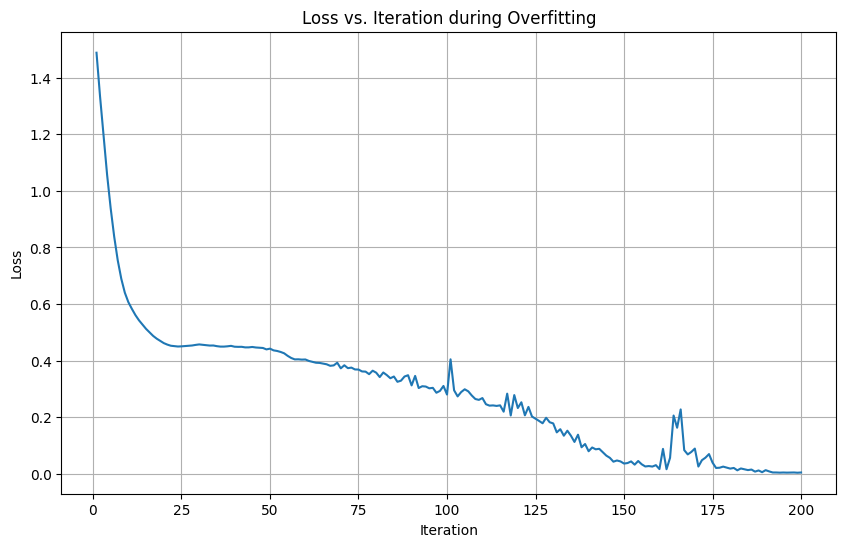

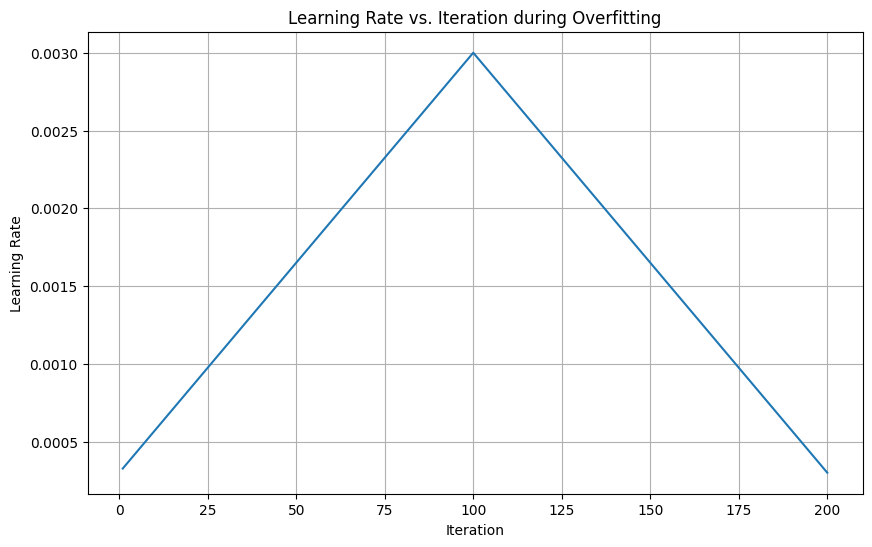

In [ ]:
simulate_overfitting(make_gvp_test_pipeline(num_layers=3, model='gvp-encoder'), iteration=200)

init pipeline, model: gvp, dataset: atpbind3d-minimal, gpus: [0]
load model gvp, kwargs: {'node_in_dim': (6, 3), 'node_h_dim': (100, 16), 'edge_in_dim': (32, 1), 'edge_h_dim': (32, 1), 'num_layers': 3, 'drop_rate': 0.1, 'output_dim': 20, 'gpu': 0}
get dataset with kwargs: {'to_slice': True, 'max_slice_length': 550, 'padding': 100}
Initialize Undersampling: all ones
Initialize Weighting: all ones
train samples: 4, valid samples: 2, test samples: 5
use cyclic lr scheduler
pipeline batch_size: 1, gradient_interval: 1
task.model: <class 'lib.custom_models.GVPWrapModel'>
sequence: IGKGFEDLMT
prediction: tensor([-0.1494, -0.0794, -0.0828, -0.0814, -0.2318, -0.2920, -0.3026, -0.1587,
        -0.0840, -0.0809], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
label: tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
bce loss: 0.6907628178596497
Overfitting...
sequence: IGKGFEDLMT
prediction: tensor([ 0.2262,  0.5360,  0.4718,  0.5630,  0.1211, -3.5715, -3.4865, -3.9448,
        -0.3763, 

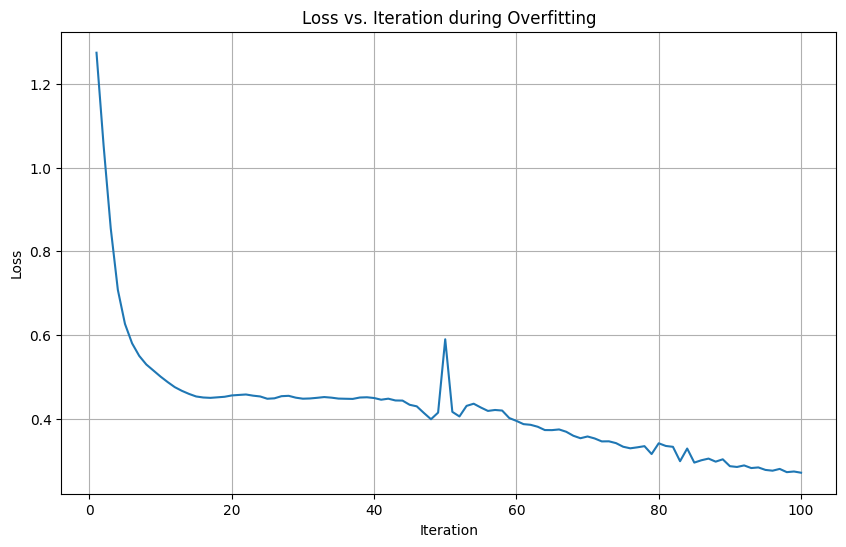

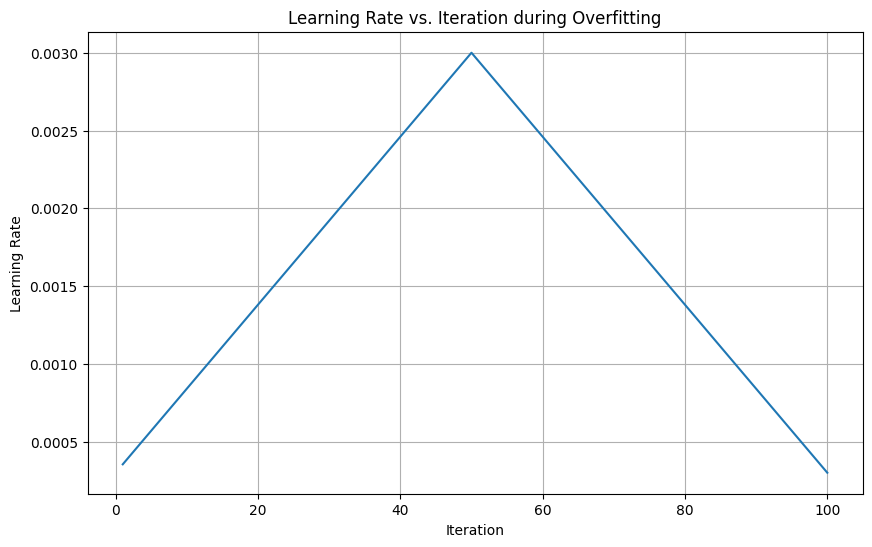

In [ ]:
simulate_overfitting(make_gvp_test_pipeline(num_layers=3, model='gvp'), iteration=200)

# Do real training

In [ ]:
pipeline_kwargs = {
    'model': 'gvp-encoder',
    'dataset': 'atpbind3d-minimal',
    'gpus': [0],
    'model_kwargs': {
        'node_in_dim': (6, 3),
        'node_h_dim': (100, 16),
        'edge_in_dim': (32, 1),
        'edge_h_dim': (32, 1),
        'num_layers': 3,
        'drop_rate': 0.1,
        'output_dim': 20,
        'gpu': 0,
    },
    'scheduler': 'cyclic',
    'scheduler_kwargs': {
        'base_lr': 3e-4,
        'max_lr': 3e-3,
        'step_size_up': 50,
        'step_size_down': 50,
        'cycle_momentum': False
    },
    'task_kwargs': {
        'normalization': False,
        'num_mlp_layer': 2,
        'metric': ['mcc'],
        'node_feature_type': 'gvp_data',
    },
    'batch_size': 1,
    'gradient_interval': 1,
    'verbose': False,
    'valid_fold_num': 0,
    'dataset_kwargs': {
        'to_slice': True,
        'max_slice_length': 550,
        'padding': 100
    },
    'num_mlp_layer': 2,
}

print('hi')
pipeline = Pipeline(**pipeline_kwargs)
train_record = pipeline.train_until_fit(max_epoch=100, patience=-1, eval_testset_intermediate=True)
